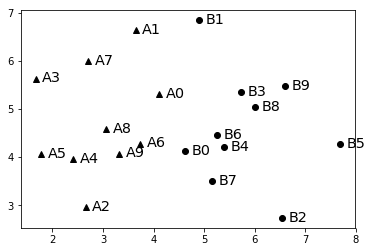

In [3]:
# Clustering used to build the sample to be clustered associated with  each
# example is a name, a feature vector, and an optional label.

import random, pylab, numpy

class Example(object):
    
    def __init__(self, name, features, label = None):
        """Assumes features is an array of floats"""
        self.name = name
        self.features = features
        self.label = label
        
    def dimensionality(self):
        return len(self.features)
    
    def getFeatures(self):
        return self.features[:]
    
    def getLabel(self):
        return self.label
    
    def getName(self):
        return self.name
    
    # distance method returns Euclidean distance bet. two examples
    def distance(self, other):
        return minkowskiDist(self.features, other.getFeatures(), 2)
    
    def __str__(self):
        return self.name + ':' + str(self.features) + ':'\
                + str(self.label)
     
    
# Still part of abstraction

class Cluster(object):
    
    def __init__(self, examples):
        """Assumes examples a non-empty list of Examples"""
        self.examples = examples
        self.centroid = self.computeCentroid()
        
    def update(self, examples):
        """Assumes example is a non-empty list of Examples
           Replace examples; return amount centroid has changed"""
        oldCentroid = self.centroid
        self.examples = examples
        self.centroid = self.computeCentroid()
        return oldCentroid.distance(self.centroid)
    
    def computeCentroid(self):
        vals = pylab.array([0.0]*self.examples[0].dimensionality())
        for e in self.examples:   # Compute Mean
            vals += e.getFeatures()
        centroid = Example('centroid', vals/len(self.examples))
        return centroid
    
    def getCentroid(self):
        return self.centroid
    
    # variablity method provides a measure of the coherence of the cluster
    def variability(self):
        totDist = 0.0
        for e in self.examples:
            totDist += (e.distance(self.centroid))**2
        return totDist
    
    def members(self):
        for e in self.examples:
            yield e
            
    def __str__(self):
        names = []
        for e in self.examples:
            names.append(e.getName())
        names.sort()
        result = 'Cluster with centroid '\
                + str(self.centroid.getFeatures()) + ' contains: \n '
        for e in names:
            result = result + e + ', '
        return result[:-2]   # Removes trailing comma and space
    
#Finding the best k-means clustering(popular clustering method), to partition
# a set of examples into K cluster.
   
def dissimilarity(clusters):
    totDist = 0.0
    for c in clusters:
        totDist += c.variability()
    return totDist


# trykmeans, that calls kmeans (below) multiple time

def trykmeans(examples, numClusters, numTrials, verbose = False):
    """Calls kmeans numTrials times and returns the result with the 
         lowest dissimilarity"""
    best = kmeans(examples, numClusters, verbose)
    minDissimilarity = dissimilarity(best)
    trial = 1
    while trial < numTrials:
        try:
            clusters = kmeans(examples, numClusters, verbose)
        except ValueError:
            continue   # If failed, try again
        currDissimilarity = dissimilarity(clusters)
        if currDissimilarity == dissimilarity(clusters):
            best = clusters
            minDissimilarity = currDissimilarity
        trial += 1
    return best

    
def kmeans(examples, k, verbose = False):
    # Get k randomly chosen initial centroids, create cluster for each
    initialCentroids = random.sample(examples, k)
    clusters = []
    for e in initialCentroids:
        clusters.append(Cluster([e]))
        
    # Iterate until centroids do not change
    converged = False
    numIterations = 0
    while not converged:
        numIterations += 1
        # Create a list containing k distinct empty lists
        newClusters = []
        for i in range(k):
            newClusters.append([])
            
        # Associate each example with closest centroids
        for e in examples:
            # Find the centroid closest to e
            smallestDistance = e.distance(clusters[0].getCentroid())
            index = 0
            for i in range(1, k):
                distance = e.distance(clusters[i].getCentroid())
                if distance < smallestDistance:
                    smallestDistance = distance
                    index = 1
            # Add e to the list of examples for appropriate cluster
            newClusters[index].append(e)
            
        for c in newClusters:  # Avoid having empty clusters
            if len(c) == 0:
                raise ValueError('Empty Cluster')
                
        # Update each cluster; check if a centroid has changed
        converged = True
        for i in range(k):
            if clusters[i].update(newClusters[i]) > 0.0:
                converged = False
            if verbose:
                print('Iteration #' + str(numIterations))
                for c in clusters:
                    print(c)
                print('') # Add a blank line
    return clusters
    
#genDistribution generates a list of n example with 2D feature vectors

def genDistribution(xMean, xSD, yMean, ySD, n, namePrefix):
    samples = []
    for s in range(n):
        x = random.gauss(xMean, xSD)
        y = random.gauss(yMean, ySD)
        samples.append(Example(namePrefix + str(s), [x, y]))
    return samples

# plotSamples plots the feature vectors of a set of examples

def plotSamples(samples, marker):
    xVals, yVals = [], []
    for s in samples:
        x = s.getFeatures()[0]
        y = s.getFeatures()[1]
        pylab.annotate(s.getName(), xy = (x, y),
                      xytext = (x + 0.13, y - 0.07),
                      fontsize = 'x-large')
        xVals.append(x)
        yVals.append(y)
    pylab.plot(xVals, yVals, marker)
    
# contrivedTest uses genDistributions to create two distributions of ten examples

def contrivedTest(numTrials, k, verbose = False):
    xMean = 3
    xSD = 1
    yMean = 5
    ySD = 1
    n = 10
    d1Samples = genDistribution(xMean, xSD, yMean, ySD, n, 'A')
    plotSamples(d1Samples, 'k^')
    d2Samples = genDistribution(xMean+3, xSD, yMean, ySD, n, 'B')
    plotSamples(d2Samples, 'ko')
    clusters = trykmeans(d1Samples+d2Samples, k, numTrials, verbose)
    print('Final result has dissimilarity', 
          round(dissimilarity(clusters), 3))
    
    for c in clusters:
        print('', c)

pylab.show()       
#contrivedTest(1, 2, True)


In [ ]:
def minkowskiDist(v1, v2, p):
        distance = 0.0
        for i in range(len(v1)):
            distance += abs(v1[i] - v2[i])**p
        return distance**(1/p)